# **Fine-tuning DeBERTaV3 to Differentiate Between AI-Generated and Human-Written Text 🧠🤖**

In this notebook, we will fine-tune the DeBERTaV3 model to distinguish between AI-generated text and text written by a person. Using datasets from Kaggle, we will train the model and then perform inference using KerasNLP. 📊📚




1.   **Data Split**:
      Divide the existing Train data into folds using stratification of label column, Label column got 2 values: 0 Human text, 1 Ai text.


2.   **Preprocessing**:
      The preprocessor takes input strings and transforms them into a dictionary (token_ids, padding_mask) containing preprocessed tensors. This process starts with tokenization, where input strings are converted into sequences of token IDs.

*   [Preprocessing Layers
](https://keras.io/api/keras_nlp/preprocessing_layers/)
*   [KerasNLP Tokenizers
](https://keras.io/api/keras_nlp/tokenizers/)


3.   **DataLoader**:
The tf.data API allows us to build complex input pipelines for training and validation datasets. These pipelines will then be fed into the corresponding model folds.

*   [Build TensorFlow input pipelines ](https://www.tensorflow.org/guide/data)


3.   **Learning rate scheduler**:
  Implementing a learning rate scheduler with a Callbacks,The learning rate initiates at lr_start and gradually tapers down to lr_min using various techniques, including:


*   step : Lowering the learning rate in step-wise manner resembling stairs.
*   cos: Utilizing a cosine curve to gradually reduce the learning rate.
*   exp: Exponentially decreasing the learning rate.


4.   **Modeling**:
  We will employ a Keras Classifier equipped with softmax activation. Use DebertaV3 as model.


*   [KerasNLP Models
](https://keras.io/api/keras_nlp/models/)
*   [Getting Started with KerasNLP](https://keras.io/guides/keras_nlp/getting_started/)


5.   **Training**:
Training the model with a total of 3 epochs to refine its performance and optimize its parameters.

6.   **Inference**:
 Inference using the trained model to determine whether the text provided originates from an AI or a human











### Dataset from Kaggle

In [1]:
!pip install -q kaggle

In [2]:
!mkdir ~/.kaggle

In [18]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [19]:
!kaggle competitions download -c llm-detect-ai-generated-text

 72% 1.00M/1.38M [00:00<00:00, 1.10MB/s]
100% 1.38M/1.38M [00:01<00:00, 1.41MB/s]


In [20]:
!unzip -q llm-detect-ai-generated-text.zip

In [6]:
#DAIGT Proper Train Dataset
!kaggle datasets download -d thedrcat/daigt-proper-train-dataset
#ArguGPT
!kaggle datasets download -d alejopaullier/argugpt

Dataset URL: https://www.kaggle.com/datasets/thedrcat/daigt-proper-train-dataset
License(s): MIT
 99% 118M/119M [00:07<00:00, 21.6MB/s]
100% 119M/119M [00:07<00:00, 17.4MB/s]
Dataset URL: https://www.kaggle.com/datasets/alejopaullier/argugpt
License(s): unknown
100% 3.26M/3.26M [00:01<00:00, 3.88MB/s]
100% 3.26M/3.26M [00:01<00:00, 2.90MB/s]


In [7]:
!unzip -q argugpt.zip
!unzip -q daigt-proper-train-dataset.zip

### Libraries

In [8]:
!pip install tensorflow==2.15.1
!pip install tensorflow-text==2.15.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 95.0 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 61.1 MB/s eta 0:00:00


In [9]:
!pip install -q keras_nlp==0.6.3 keras-core==0.1.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.5/584.5 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 49.9 MB/s eta 0:00:00


In [21]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras_nlp
import keras_core as keras
import keras_core.backend as K

import torch
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [22]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasNLP:", keras_nlp.__version__)

TensorFlow: 2.15.1
Keras: 0.1.7
KerasNLP: 0.6.3


### Configuration

In [23]:
class CFG:
  verbose = 0

  wandb = True
  competition = "llm-detect-ai-generated-text"
  _wandb_kernel = "awsaf49"
  comment = "DebartaV3-MaxSeq_200-torch"

  preset = "deberta_v3_base_en"
  sequence_length = 200

  device = 'TPU'
  seed = 42

  num_folds = 5 #total folds
  selected_folds = [0,1] #folds to train

  epochs = 3
  batch_size = 3
  drop_remainder = True
  cache= True

  scheduler = "cosine" #Learning rate scheduler

  class_names = ["real","fake"]
  num_classes = len(class_names)
  class_labels = list (range(num_classes))
  label2name = dict(zip(class_labels,class_names))
  name2label = {v: k for k, v in label2name.items()}

### Hardware

In [24]:
def get_device():
    "Detect and intializes GPU/TPU automatically"
    try:
        # detect and init the TPU
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

        # instantiate a distribution strategy
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print(f'> Running on TPU', tpu.master(), end=' | ')
        print('Num of TPUs: ', strategy.num_replicas_in_sync)
        device=CFG.device
    except:
        # If TPU is not available, detect GPUs
        gpus = tf.config.list_logical_devices('GPU')
        ngpu = len(gpus)
         # Check number of GPUs
        if ngpu:
            # Set GPU strategy
            strategy = tf.distribute.MirroredStrategy(gpus) # single-GPU or multi-GPU
            # Print GPU details
            print("> Running on GPU", end=' | ')
            print("Num of GPUs: ", ngpu)
            device='GPU'
        else:
            # If no GPUs are available, use CPU
            print("> Running on CPU")
            strategy = tf.distribute.get_strategy()
            device='CPU'
    return strategy, device

In [25]:
strategy, CFG.device = get_device()
CFG.replicas = strategy.num_replicas_in_sync

> Running on GPU | Num of GPUs:  1


### Reproducibility

In [26]:
#Sets value for random seed to produce similar result in each run.
keras.utils.set_random_seed(CFG.seed)

### Train Data

In [27]:
df = pd.read_csv("train_essays.csv")
df.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [28]:
df['label'] = df.generated.copy()
df['name'] = df.generated.map(CFG.label2name)
df.head()

,id,prompt_id,text,generated,label,name
0,0059830c,0,Cars. Cars have been around since they became ...,0,0,real
1,005db917,0,Transportation is a large necessity in most co...,0,0,real
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0,0,real
3,00940276,0,How often do you ride in a car? Do you drive a...,0,0,real
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0,0,real


In [29]:
print(f"Length of Train Data: {len(df)}")

Length of Train Data: 1378


<ipython-input-30-2445fa490221>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


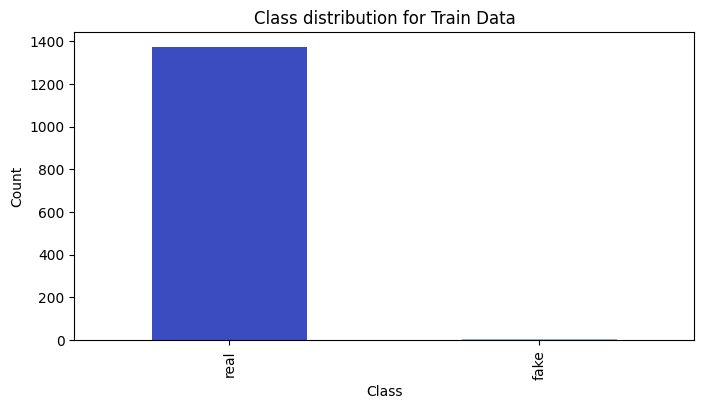

In [30]:
cmap = mpl.cm.get_cmap('coolwarm')
plt.figure(figsize=(8, 4))
df.name.value_counts().plot.bar(color=[cmap(0.0), cmap(0.25), cmap(0.65), cmap(0.9), cmap(1.0)])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class distribution for Train Data")
plt.show()

In [31]:
# load external data
ext_data1 = pd.read_csv("train_drcat_04.csv")
ext_data2 = pd.read_csv("argugpt.csv")[["id","text","model"]]

ext_data2.rename(columns = {'model':'source'}, inplace = True)
ext_data2["label"] = 1

ext_df = pd.concat([
    ext_data1[ext_data1.source == 'persuade_corpus'].sample(10000),
    ext_data1[ext_data1.source!='persuade_corpus'],
])

ext_df['name'] = ext_df.label.map(CFG.label2name)

print(f'length of the External Data: {len(ext_df)}')

length of the External Data: 28210


In [32]:
ext_df.head()

,essay_id,text,label,source,prompt,fold,name
20120,83BB96F966DB,Students would benefit from being able to atte...,0,persuade_corpus,NaN,2,real
43529,80D6E256AA49,Landform or alien? The face on Mars looks pret...,0,persuade_corpus,NaN,2,real
2942,4A028F63CFCA,The human body is a complex network of muscles...,0,persuade_corpus,NaN,7,real
2977,5782F64504B9,Summer projects are a means by which schools a...,0,persuade_corpus,NaN,9,real
31921,97DD2D770B03,"Dear Mr. Senator,\n\nI have decided to express...",0,persuade_corpus,NaN,6,real


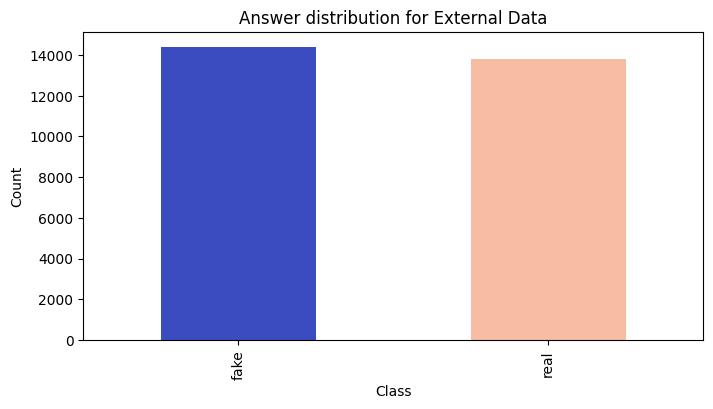

In [33]:
plt.figure(figsize=(8, 4))
ext_df.name.value_counts().plot.bar(color=[cmap(0.0), cmap(0.65)])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Answer distribution for External Data")
plt.show()

### Combine External and Train Data

In [34]:
#data=pd.concat([df,ext_df])
df = ext_df.copy().reset_index(drop=True)
print(f'length of the Combined Data: {len(df)}')
df.head()

length of the Combined Data: 28210


,essay_id,text,label,source,prompt,fold,name
0,83BB96F966DB,Students would benefit from being able to atte...,0,persuade_corpus,NaN,2,real
1,80D6E256AA49,Landform or alien? The face on Mars looks pret...,0,persuade_corpus,NaN,2,real
2,4A028F63CFCA,The human body is a complex network of muscles...,0,persuade_corpus,NaN,7,real
3,5782F64504B9,Summer projects are a means by which schools a...,0,persuade_corpus,NaN,9,real
4,97DD2D770B03,"Dear Mr. Senator,\n\nI have decided to express...",0,persuade_corpus,NaN,6,real


### Data Split

In [35]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=CFG.num_folds, shuffle=True, random_state=CFG.seed)

df = df.reset_index (drop=True)
df['stratify'] = df.label.astype(str)+df.source.astype(str)

df['fold'] = -1

for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['stratify'])):
    df.loc[val_idx, 'fold'] = fold

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


In [36]:
df.groupby(["fold", "name", "source"]).size()

fold  name  source           
0     fake  chat_gpt_moth         484
            darragh_claude_v6     200
            darragh_claude_v7     200
            falcon_180b_v1        211
            llama2_chat           484
                                 ... 
4     fake  radek_500             100
            train_essays            1
      real  original_moth         484
            persuade_corpus      2000
            train_essays          275
Length: 63, dtype: int64

### Preprocessing

* Take input string and transforms them into a dictionary "**token_ids**",
"**padding_mask**"  containing preprocessed tensors.

In [37]:
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset=CFG.preset,
    sequence_length = CFG.sequence_length)

2464616/2464616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [38]:
df.text.iloc[0]

'Students would benefit from being able to attend classes from home because some students would rather want to be able to work in their own comfortable environment and be able to work at their own pace.\n\nStudents would benefit from being able to attend classes at home because they can work at their pace because if the students missed a day or two of school, the online class is there to provide them easy access to work they might have missed. Another point is, some students tend to much rather like to work in an environment they feel comfortable in or that they feel safe in. Lastly, It would benefit their learning skills by having a tool to use that could be helpful for them when they attend school personally.\n\nStudents working at their own pace could be helpful and beneficial to them in many ways. Having to be rushed or pressured to do work may not be the best for any grade school students. If a student missed a couple days of school, the online class is there to provide for the le

In [39]:
input = preprocessor(df.text.iloc[0])

for k, v in input.items():
    print (k, ":", v.shape)

token_ids : torch.Size([200])
padding_mask : torch.Size([200])


In [40]:
# function to transform each text
def preprocess_fn(text, label=None):
    text = preprocessor(text) # Preprocess text
    return (text, label) if label is not None else text


### **DataLoader**





In [41]:
def build_dataset(texts, labels = None, batch_size = 32, cache=False, drop_remainder=True, repeat=False, shuffle=1024):
  AUTO = tf.data.AUTOTUNE
  slices = (texts,) if labels is None else (texts, labels)

  ds = tf.data.Dataset.from_tensor_slices(slices)
  ds = ds.cache() if cache else ds
  ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)

  ds = ds.repeat() if repeat else ds
  opt = tf.data.Options()
  if shuffle:
    ds = ds.shuffle( shuffle, seed =CFG.seed)
    opt.experimental_deterministic = False

  ds =ds.with_options(opt)
  ds= ds.batch(batch_size, drop_remainder = drop_remainder)
  ds = ds.prefetch(AUTO)
  return ds


*   Fetch Train/Valid Dataset for a given fold.


In [42]:
def get_datasets(fold):
  train_df = df[df.fold != fold].sample(frac=1)
  train_texts= train_df.text.tolist()
  train_labels = train_df.label.tolist()

  train_ds = build_dataset(train_texts, train_labels, batch_size=CFG.batch_size*CFG.replicas, cache=CFG.cache,shuffle= True, drop_remainder=True, repeat=True)

  valid_df= df[df.fold == fold].sample(frac=1)
  valid_texts = valid_df.text.tolist()
  valid_labels = valid_df.label.tolist()

  valid_ds = build_dataset(valid_texts, valid_labels, batch_size=min(CFG.batch_size*CFG.replicas, len(valid_df)), cache=CFG.cache,shuffle= False, drop_remainder=True, repeat=False)

  return (train_ds, train_df), (valid_ds, valid_df)

### Wandb

In [43]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.6 MB/s eta 0:00:00


In [44]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient  # Import UserSecretsClient
    user_secrets = UserSecretsClient()  # Create secrets client instance
    api_key = user_secrets.get_secret("WANDB")  # Get API key from Kaggle secrets
    wandb.login(key=api_key)  # Login to wandb with the API key
    anonymous = None  # Set anonymous mode to None
except:
    anonymous = 'must'  # Set anonymous mode to 'must'
    wandb.login(anonymous=anonymous, relogin=True)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [45]:
# Initializes the W&B run with a config file and W&B run settings.
def wandb_init(fold):
    config = {k: v for k, v in dict(vars(CFG)).items() if '__' not in k}  # Create config dictionary
    config.update({"fold": int(fold)})  # Add fold to config
    run = wandb.init(project="llm-fake-text",
                     name=f"fold-{fold}|max_seq-{CFG.sequence_length}|model-{CFG.preset}",
                     config=config,
                     group=CFG.comment,
                     save_code=True)
    return run

# Log best result for error analysis
def log_wandb():
    wandb.log({'best_auc': best_auc, 'best_loss': best_loss, 'best_epoch': best_epoch})

# Fetch W&B callbacks
def get_wb_callbacks(fold):
    wb_metr = wandb.keras.WandbMetricsLogger()
    return [wb_metr]  # Return WandB callbacks

### Learning rate

In [46]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 0.6e-6, 0.5e-6 * batch_size, 0.3e-6
    lr_ramp_ep, lr_sus_ep, lr_decay = 1, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

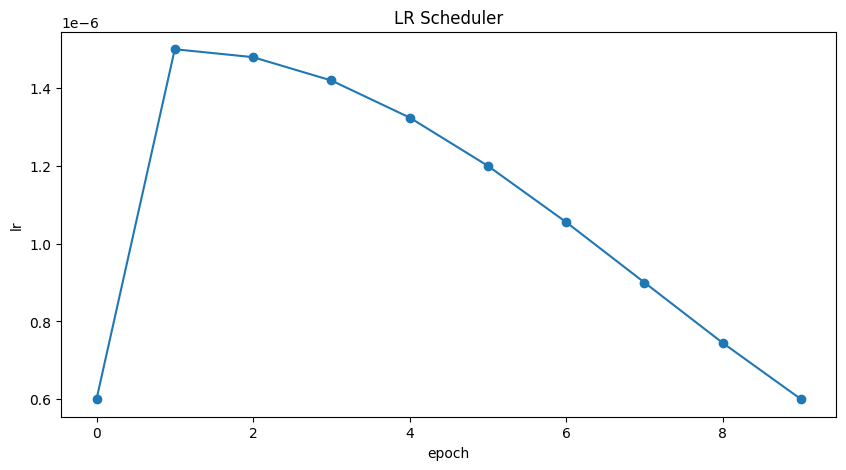

In [47]:
_=get_lr_callback(CFG.batch_size*CFG.replicas, plot=True)


### CallBacks

In [48]:
def get_callbacks(fold):
  callbacks= []
  lr_cb = get_lr_callback(CFG.batch_size*CFG.replicas)
  ckpt_cb = keras.callbacks.ModelCheckpoint(f'fold{fold}.keras',
                                            monitor='val_auc',
                                            save_best_only=True,
                                            save_weights_only=False,
                                            mode='max') # Model checkpoint callback

  callbacks.extend([lr_cb, ckpt_cb])

  if CFG.wandb:
    wb_cbs = get_wb_callbacks(fold)
    callbacks.extend(wb_cbs)
    return callbacks

### Modeling

* **KerasNLP Classifier**: using https://keras.io/guides/keras_nlp/getting_started/ as a guide.
*Our approach involves using "**keras_nlp.models.XXClassifier**" to process each text and generatie logits. These logits are passed through a softmax function to produce the final output.
* Use pre-trained model called "**DebertaV3**"



In [49]:
def build_model():
  classifier = keras_nlp.models.DebertaV3Classifier.from_preset(
      CFG.preset,
      preprocessor = None,
      num_classes = 1 #One output per one option, 5 options = 5 outputs
      )
  inputs = classifier.input
  logits = classifier(inputs)

  outputs = keras.layers.Activation('sigmoid')(logits)
  model = keras.Model(inputs, outputs)

  model.compile (
      optimizer = keras.optimizers.AdamW(5e-6),
      loss= keras.losses.BinaryCrossentropy(label_smoothing = 0.02),
      metrics = [keras.metrics.AUC(name='auc')],
      jit_compile = True
  )

  return model

In [50]:
model = build_model()

735557816/735557816 ━━━━━━━━━━━━━━━━━━━━ 33s 0us/step


/usr/local/lib/python3.10/dist-packages/keras_core/src/trainers/trainer.py:166: UserWarning: `jit_compile` is not yet enabled for the PyTorch backend. Proceeding with `jit_compile=False`.
  warnings.warn(


In [51]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃    Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer) │ (None, None)           │          0 │ -                          │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ token_ids (InputLayer)    │ (None, None)           │          0 │ -                          │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ deberta_v3_classifier     │ (None, 1)              │ 184,422,9… │ padding_mask[0][0],        │
│ (DebertaV3Classifier)     │                        │            │ token_ids[0][0]            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ activation (Activation)   │ (None, 1)              │          0 │ deberta_v3_classifier[0][… │
└───────────────────────────┴────────────────────────┴────────────┴────────────────────────────┘

 Total params: 184,422,913 (703.52 MB)

 Trainable params: 184,422,913 (703.52 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [52]:
for fold in CFG.selected_folds:

  if CFG.wandb:
    run = wandb_init(fold)

  (train_ds, train_df), (valid_ds, valid_df) = get_datasets(fold)

  callbacks = get_callbacks(fold)

  print('#' * 50)
  print(f'\tFold: {fold + 1} | Model: {CFG.preset}\n\tBatch Size: {CFG.batch_size * CFG.replicas} | Scheduler: {CFG.scheduler}')
  print(f'\tNum Train: {len(train_df)} | Num Valid: {len(valid_df)}')
  print('#' * 50)

  K.clear_session()
  with strategy.scope():
    model = build_model()


  history = model.fit(
      train_ds,
      validation_data=valid_ds,
      epochs=CFG.epochs,
      callbacks=callbacks,
      steps_per_epoch=int(len(train_df) / CFG.batch_size / CFG.replicas),
  )

  best_epoch = np.argmax(model.history.history['val_auc'])
  best_auc = model.history.history['val_auc'][best_epoch]
  best_loss = model.history.history['val_loss'][best_epoch]

  print(f'\n{"=" * 17} FOLD {fold} RESULTS {"=" * 17}')
  print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST AUC   : {best_auc:.3f}\n>>>> BEST Epoch : {best_epoch}')
  print('=' * 50)

  if CFG.wandb:
    log_wandb()
    wandb.run.finish()

  print("\n\n")

wandb: Currently logged in as: anony-moose-977766824028876109. Use `wandb login --relogin` to force relogin


##################################################
	Fold: 1 | Model: deberta_v3_base_en
	Batch Size: 3 | Scheduler: cosine
	Num Train: 22568 | Num Valid: 5642
##################################################
Epoch 1/3
7522/7522 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - auc: 0.9438 - loss: 0.2593

wandb: ERROR Unable to log learning rate.


7522/7522 ━━━━━━━━━━━━━━━━━━━━ 1491s 198ms/step - auc: 0.9439 - loss: 0.2593 - val_auc: 0.9979 - val_loss: 0.1154 - learning_rate: 6.0000e-07
Epoch 2/3
7522/7522 ━━━━━━━━━━━━━━━━━━━━ 1497s 199ms/step - auc: 0.9981 - loss: 0.0797 - val_auc: 0.9985 - val_loss: 0.0992 - learning_rate: 1.5000e-06
Epoch 3/3
7522/7522 ━━━━━━━━━━━━━━━━━━━━ 1498s 199ms/step - auc: 0.9990 - loss: 0.0689 - val_auc: 0.9967 - val_loss: 0.1224 - learning_rate: 1.4796e-06

================= FOLD 0 RESULTS =================
>>>> BEST Loss  : 0.099
>>>> BEST AUC   : 0.999
>>>> BEST Epoch : 1


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


best_auc,▁
best_epoch,▁
best_loss,▁
epoch/auc,▁▇█
epoch/epoch,▁▅█
epoch/learning_rate,▁██
epoch/loss,█▂▁
epoch/val_auc,▆█▁
epoch/val_loss,▆▁█
best_auc,0.99854
best_epoch,1


##################################################
	Fold: 2 | Model: deberta_v3_base_en
	Batch Size: 3 | Scheduler: cosine
	Num Train: 22568 | Num Valid: 5642
##################################################
Epoch 1/3
7522/7522 ━━━━━━━━━━━━━━━━━━━━ 1505s 200ms/step - auc: 0.9451 - loss: 0.2722 - val_auc: 0.9977 - val_loss: 0.1103 - learning_rate: 6.0000e-07
Epoch 2/3
7522/7522 ━━━━━━━━━━━━━━━━━━━━ 1505s 200ms/step - auc: 0.9980 - loss: 0.0831 - val_auc: 0.9993 - val_loss: 0.0859 - learning_rate: 1.5000e-06
Epoch 3/3
7522/7522 ━━━━━━━━━━━━━━━━━━━━ 1493s 199ms/step - auc: 0.9989 - loss: 0.0733 - val_auc: 0.9978 - val_loss: 0.0967 - learning_rate: 1.4796e-06

================= FOLD 1 RESULTS =================
>>>> BEST Loss  : 0.086
>>>> BEST AUC   : 0.999
>>>> BEST Epoch : 1


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


best_auc,▁
best_epoch,▁
best_loss,▁
epoch/auc,▁▇█
epoch/epoch,▁▅█
epoch/learning_rate,▁██
epoch/loss,█▂▁
epoch/val_auc,▁█▂
epoch/val_loss,█▁▄
best_auc,0.99926
best_epoch,1


### Predictions

In [53]:
predictions = model.predict(
    valid_ds,
    batch_size=min(CFG.batch_size * CFG.replicas * 2, len(valid_df)),
    verbose=1
)

1880/1880 ━━━━━━━━━━━━━━━━━━━━ 166s 88ms/step


In [55]:
pred_answers = (predictions > 0.5).astype(int).squeeze()
true_answers = valid_df.label.values
print("# Predictions\n")
for i in range(20):
    row = valid_df.iloc[i]
    text  = row.text
    pred_answer = CFG.label2name[pred_answers[i]]
    true_answer = CFG.label2name[true_answers[i]]
    print(f"❓ Text {i+1}:\n{text[:100]} .... {text[-100:]}\n")
    print(f"✅ True: {true_answer}\n")
    print(f"Predicted: {pred_answer}\n")
    print("-"*90, "\n")

# Predictions

❓ Text 1:
In recent years, there has been a lot of discussion about the impact of video games on behavior, spe .... ocial behavior. Retrieved from <https://www.sciencedirect.com/science/article/pii/S0193397316300151>

✅ True: fake

Predicted: fake

------------------------------------------------------------------------------------------ 

❓ Text 2:
As an eighth-grade student, I believe that completing high school earlier than the traditional age o .... ers to consider completing high school early and take advantage of all the benefits it has to offer.

✅ True: fake

Predicted: fake

------------------------------------------------------------------------------------------ 

❓ Text 3:
Seeking multiple opinions when making an important decision or looking for advice is almost always t .... iases. The consensus of multiple independent advisors is most likely to result in the wisest choice.

✅ True: fake

Predicted: fake

----------------------------------------------------

### Reference





*   [KerasNLP](https://keras.io/api/keras_nlp/)
*   [Triple Stratified KFold with TFRecords
](https://www.kaggle.com/code/cdeotte/triple-stratified-kfold-with-tfrecords)
*   [Detect Fake Text: KerasNLP [TF/Torch/JAX][Train]](https://www.kaggle.com/code/awsaf49/detect-fake-text-kerasnlp-tf-torch-jax-train)
* [How to Fine-Tune BERT for Text Classification](https://wandb.ai/akshayuppal12/Finetune-BERT-Text-Classification/reports/How-to-Fine-Tune-BERT-for-Text-Classification--Vmlldzo4OTk4MzY?galleryTag=nlp)

By Montassar Jaziri

